# Leves | Modelo Fast | ML

Autor: Felipe Oliveira

------------

## Objetivo
Este notebook objetiva a testagem de modelos de machine learning e conseguinte comparação frente ao modelo de regressão logística vigente para o público de não clientes

março de 2022

# Pacotes

In [0]:
!pip install shap
!pip install lightgbm
!pip install xgboost

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from pyspark.sql.functions import *
from pyspark.sql.functions import expr
from pyspark.sql.types import ByteType,ShortType,LongType,IntegerType,DoubleType
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import statsmodels.api as sm

# Classes

In [0]:
%run /Users/felipe.espirito@bv.com.br/Modulos

# Funções

In [0]:
%run /Users/lucas.lima@bv.com.br/funcoes/funcoes_lucas

In [0]:
%run /Users/felipe.espirito@bv.com.br/funcoes

# Dados

In [0]:
%sql 
refresh table cred_felipeoliveira.base_ncli_spark;
select * from cred_felipeoliveira.base_ncli_spark limit 10;

NuProposta,NuCpfCnpj,DtPrimeiroCadastro,QtMesesEmprego,DsEstadoCivil,CdUfCliente,CPF_main,Safra_main,P3_ult_ret,P4_BVS,SCORE_HRIM,SCORE_HSPN,SCORE_HVLD,QuodScore_v2,score_ajust,inad30,elegiveis,QuodScore,Blend_Novo_1_1_arred,RUPD,ScoreBacen,WoE_cd_mosaic,WoE_score_ajust,WoE_mpv_score,WoE_pb_qt_propavgdiaauto_pv,WoE_pb_qt_diasfina_max_pv,WoE_pb_td_primcompr_pv,WoE_pb_td_ultcomprfin_pv,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_HRIM,yhat1,yhat1_2,yhat1_3,yhat1_4,yhat1_5,logito_CRISP,logito_yhat1_4,yhat_blend,yhat_blend2,yhat_dt,yhat_dt1_1,yhat_rf1_1,qsyhat1,qsyhat1_2,qsyhat1_3,qsyhat1_4,qsyhat1_5,qsyhat_rf1_1,qsyhat_dt1_1,qsyhat_blend,qsyhat_blend2,qsP3_ult_ret,qsP4_BVS,qsSCORE_HRIM,qsSCORE_HSPN,qsSCORE_HVLD,qsQuodScore_v2,qsQuodScore,qsBlend_Novo_1_1_arred,prob,prob90m12,yhat_blend_90m12
271583900,442543000,-99999999,185,CASADO,SC,442543000,202108,873.0,631.0,963.0,963.0,978.0,919,621.0,0,1,927.0,990.0,8.5,-9.9999999E7,0.24457,0.064299,0.183219,0.092449,0.093345,-0.065547,-0.047612,0.388056,0.325496,0.385174,0.428941,0.333876,0.499355,0.30193,0.258504,1.320727,989.9394441233449,986.0078786844251,991.1679704671711,989.3265530159214,987.7893461533762,4.59511985013459,4.529265395229037,989.5358390412935,989.5121162295407,0.016415868673050615,983.5841313269493,984.7755519626701,9.0,8.0,9.0,9.0,9.0,9,6,9.0,9.0,9.0,8.0,9.0,9.0,6.0,8,9.0,8.0,0.010464160958706503,0.034303456490990314,965.6965435090096
391802534,478086245,-99999999,24,SOLTEIRO,RO,478086245,202108,668.0,547.0,618.0,618.0,947.0,570,698.0,0,1,788.0,950.0,6.0,-9.9999999E7,0.032051,0.333966,0.183219,0.092449,0.093345,0.082153,-0.047612,0.388056,0.042456,0.266808,0.318002,0.005628,0.240377,0.201609,0.258504,-0.112777,963.607809147516,975.0290625448395,974.0092552102645,973.0998177215893,959.1244849232692,2.9444389791664403,3.5883536017767477,973.0227292273621,973.2694868657069,0.027680730986294005,972.319269013706,967.7709638504562,3.0,5.0,5.0,4.0,2.0,3,4,4.0,4.0,0.0,5.0,2.0,2.0,3.0,0,3.0,4.0,0.026977270772637896,0.08163906496024853,918.3609350397514
352151216,547150679,-99999999,120,CASADO,MG,547150679,202108,791.0,618.0,726.0,726.0,951.0,959,-9.9999999E7,0,1,864.0,958.0,6.5,-9.9999999E7,0.005647,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,0.279543,0.197557,0.266808,0.318002,0.333876,0.240377,0.201609,-0.012762,0.095048,978.1423356684757,979.6157270646861,977.4402489326545,977.8178600815154,977.9478782861428,3.1271781596874924,3.786035958643575,977.7236417772242,977.883769917946,0.017051153460381142,982.9488465396189,981.2368080213379,6.0,6.0,6.0,6.0,6.0,8,6,6.0,6.0,6.0,7.0,5.0,5.0,3.0,9,6.0,5.0,0.02227635822277585,0.06786654455126406,932.133455448736
362418145,572298307,-99999999,168,SOLTEIRO,CE,572298307,202108,669.0,530.0,866.0,866.0,985.0,861,554.0,0,1,865.0,970.0,7.25,-9.9999999E7,0.009733,0.064299,0.00945,0.092449,0.179955,0.082153,0.206627,0.279543,0.042456,-0.057811,0.318002,0.143172,0.222394,0.168483,0.258504,0.524613,980.1453956713209,977.3786567619508,980.9888742426461,981.919932246628,962.607106102984,3.4760986898352733,3.9946996672618518,981.9218163952149,981.7767633216871,0.019000853970964987,980.999146029035,977.2850843540716,6.0,6.0,7.0,7.0,2.0,6,5,7.0,7.0,0.0,5.0,8.0,8.0,8.0,5,6.0,6.0,0.01807818360478508,0.05572349160569945,944.2765083943005
771338535,788131230,-99999999,125,SOLTEIRO,PA,788131230,202108,729.0,485.0,678.0,678.0,943.0,769,602.0,0,1,850.0,802.0,2.5,-9.9999999E7,0.005647,0.064299,0.183219,0.092449,0.093345,-0.065547,-0.047612,0.103328,0.197557,0.162961,0.127051,0.143172,0.222394,0.168483,0.258504,0.018759,965.7941505281135,971.3761633051827,971.0817339578407,970.9619426522524,970.442525730764,1.398841577171979,3.5096799815700024,969.2753254669341,969.2040351907965,0.027680730986294005,972.319269013706,970.5137438388983,3.0,4.0,4.0,4.0,4.0,4,4,4.0,4.0,2.0,3.0,4.0,4.0,3.0,3,5.0,0.0,0.030724674533065932,0.0927121015709311

cria_fxs(nbase1,nbase2,nvar,n_fxs,nova_var) | última atualização 08/03/2022

calc_IV(nbase1,nvar_fx,ntarget) | última atualização 11/03/2022

In [0]:
base_ncli=spark.sql('''
  select * from cred_felipeoliveira.base_ncli_spark
  ''')
print('Base Não Clientes: ', base_ncli.count())

Base Não Clientes: 150969

aplicaRUPD(nbase,nvar) | Última atualização: 30/03/2022

encontra_modelo(X, y, classificador, n_divisoes, n_repeticoes,hiperparams = None, scoring="accuracy", random_state=1109) 
 Última atualização: 21/03/2022

In [0]:
base_ncli_pd=base_ncli.toPandas()

In [0]:
base_ncli_pd

,NuProposta,NuCpfCnpj,DtPrimeiroCadastro,QtMesesEmprego,DsEstadoCivil,CdUfCliente,CPF_main,Safra_main,P3_ult_ret,P4_BVS,SCORE_HRIM,SCORE_HSPN,SCORE_HVLD,QuodScore_v2,score_ajust,inad30,elegiveis,QuodScore,Blend_Novo_1_1_arred,RUPD,ScoreBacen,WoE_cd_mosaic,WoE_score_ajust,WoE_mpv_score,WoE_pb_qt_propavgdiaauto_pv,WoE_pb_qt_diasfina_max_pv,WoE_pb_td_primcompr_pv,WoE_pb_td_ultcomprfin_pv,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_HRIM,yhat1,yhat1_2,yhat1_3,yhat1_4,yhat1_5,logito_CRISP,logito_yhat1_4,yhat_blend,yhat_blend2,yhat_dt,yhat_dt1_1,yhat_rf1_1,qsyhat1,qsyhat1_2,qsyhat1_3,qsyhat1_4,qsyhat1_5,qsyhat_rf1_1,qsyhat_dt1_1,qsyhat_blend,qsyhat_blend2,qsP3_ult_ret,qsP4_BVS,qsSCORE_HRIM,qsSCORE_HSPN,qsSCORE_HVLD,qsQuodScore_v2,qsQuodScore,qsBlend_Novo_1_1_arred,prob,prob90m12,yhat_blend_90m12
0,421134950,2442722046,-99999999,60,SOLTEIRO,RS,2442722046,202108,818.0,654.0,770.0,770.0,945.0,759,-99999999.0,0,1,332.0,923.0,4.75,-99999999.0,0.009733,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,0.388056,0.197557,0.266808,0.318002,0.005628,0.222394,0.201609,0.258504,0.392442,970.862143,976.651916,979.018290,978.007448,961.278004,2.4838238126491685,3.794813,977.3731380111556,977.2197893887891,0.008434,991.565823,979.551779,4.0,5.0,6.0,6.0,2.0,7,7,5.0,5.0,7.0,8.0,6.0,6.0,3.0,3,0.0,3.0,0.02262686198884445,0.06888781926274845,931.1121807372515
1,421134304,2682097901,-99999999,120,CASADO,SC,2682097901,202108,699.0,542.0,843.0,843.0,981.0,976,147.0,0,1,949.0,956.0,6.25,-99999999.0,0.005647,-0.172671,-0.059677,0.092449,-0.057576,-0.065547,-0.047612,-0.051340,0.197557,-0.057811,0.127051,0.333876,-0.135236,0.028386,-0.012762,0.392442,979.204025,973.810548,976.396542,977.949682,963.240913,3.07856827913314,3.792131,977.8105264624093,977.4428885314355,0.032038,967.961993,975.769037,6.0,5.0,5.0,6.0,2.0,6,3,6.0,5.0,1.0,5.0,7.0,7.0,7.0,9,9.0,5.0,0.02218947353759071,0.06761354426235222,932.3864557376478
2,421131349,2720562009,-99999999,65,CASADO,RS,2720562009,202108,869.0,434.0,790.0,790.0,950.0,930,634.0,0,1,886.0,943.0,5.50,-99999999.0,0.244570,0.064299,0.183219,0.257332,-0.057576,0.082153,-0.047612,0.103328,0.197557,0.162961,0.318002,0.333876,0.240377,0.168483,0.258504,0.392442,983.081941,972.691919,975.998327,975.863367,984.660732,2.8060150147989074,3.699592,975.5584324606083,975.5288659671552,0.027681,972.319269,976.268603,7.0,4.0,5.0,5.0,9.0,6,4,5.0,5.0,9.0,2.0,6.0,6.0,3.0,8,7.0,4.0,0.02444156753939175,0.07419083405083571,925.8091659491643
3,401640897,2724075340,-99999999,36,SOLTEIRO,MS,2724075340,202108,655.0,530.0,724.0,724.0,958.0,913,1.0,0,1,886.0,916.0,4.75,-99999999.0,0.005647,-0.172671,-0.193467,-0.138807,-0.057576,-0.242013,-0.047612,0.103328,0.197557,-0.057811,0.127051,0.333876,0.222394,-0.491549,0.258504,0.095048,970.423155,975.028012,973.921152,974.519446,961.358168,2.3891995658308165,3.644029,973.8575757490164,973.9048523394473,0.027681,972.319269,975.959837,4.0,5.0,5.0,5.0,2.0,6,4,5.0,5.0,0.0,5.0,5.0,5.0,4.0,7,7.0,2.0,0.026142424250983565,0.07918236109034837,920.8176389096516
4,431107692,2854070666,-99999999,60,CASADO,MG,2854070666,202108,829.0,552.0,578.0,578.0,878.0,894,117.0,0,1,618.0,932.0,5.25,-99999999.0,-0.322173,-0.172671,-0.059677,-0.138807,-0.057576,0.082153,-0.047612,-0.487331,-0.508048,-0.509439,-0.480301,-0.545421,-0.521438,-0.491549,-0.495893,-0.210757,957.451630,966.968959,962.795729,960.044267,959.595404,2.6178251095094844,3.179207,960.1170773127544,959.9333061621962,0.032038,967.961993,968.701397,2.0,3.0,3.0,2.0,2.0,4,3,2.0,2.0,8.0,6.0,2.0,1.0,1.0,7,0.0,3.0,0.03988292268724558,0.11998486496793559,880.0151350320644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15096

# Conversões

In [0]:
base_ncli_pd["Safra_main"] = pd.to_datetime(base_ncli_pd["Safra_main"].astype(str), format='%Y%m')

# Análises scores

### KS

# Categorização das variáveis

A categorização das variáveis (com exceção dos scores) foi feita apenas para o público não cliente.
O Rémi está fazendo para os clientes.

In [0]:
base_ncli_cat=base_ncli_pd[(base_ncli_pd.Safra_main < "2021-11")]
base_ncli_cat=base_ncli_cat.fillna(-99999999)

In [0]:
base_ncli_cat.head()

,NuProposta,NuCpfCnpj,DtPrimeiroCadastro,QtMesesEmprego,DsEstadoCivil,CdUfCliente,CPF_main,Safra_main,P3_ult_ret,P4_BVS,SCORE_HRIM,SCORE_HSPN,SCORE_HVLD,QuodScore_v2,score_ajust,inad30,elegiveis,QuodScore,Blend_Novo_1_1_arred,RUPD,ScoreBacen,WoE_cd_mosaic,WoE_score_ajust,WoE_mpv_score,WoE_pb_qt_propavgdiaauto_pv,WoE_pb_qt_diasfina_max_pv,WoE_pb_td_primcompr_pv,WoE_pb_td_ultcomprfin_pv,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_HRIM,yhat1,yhat1_2,yhat1_3,yhat1_4,yhat1_5,logito_CRISP,logito_yhat1_4,yhat_blend,yhat_blend2,yhat_dt,yhat_dt1_1,yhat_rf1_1,qsyhat1,qsyhat1_2,qsyhat1_3,qsyhat1_4,qsyhat1_5,qsyhat_rf1_1,qsyhat_dt1_1,qsyhat_blend,qsyhat_blend2,qsP3_ult_ret,qsP4_BVS,qsSCORE_HRIM,qsSCORE_HSPN,qsSCORE_HVLD,qsQuodScore_v2,qsQuodScore,qsBlend_Novo_1_1_arred,prob,prob90m12,yhat_blend_90m12
0,421134950,2442722046,-99999999,60,SOLTEIRO,RS,2442722046,2021-08-01,818.0,654.0,770.0,770.0,945.0,759,-99999999.0,0,1,332.0,923.0,4.75,-99999999.0,0.009733,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,0.388056,0.197557,0.266808,0.318002,0.005628,0.222394,0.201609,0.258504,0.392442,970.862143,976.651916,979.018290,978.007448,961.278004,2.4838238126491685,3.794813,977.3731380111556,977.2197893887891,0.008434,991.565823,979.551779,4.0,5.0,6.0,6.0,2.0,7,7,5.0,5.0,7.0,8.0,6.0,6.0,3.0,3,0.0,3.0,0.02262686198884445,0.06888781926274845,931.1121807372515
1,421134304,2682097901,-99999999,120,CASADO,SC,2682097901,2021-08-01,699.0,542.0,843.0,843.0,981.0,976,147.0,0,1,949.0,956.0,6.25,-99999999.0,0.005647,-0.172671,-0.059677,0.092449,-0.057576,-0.065547,-0.047612,-0.051340,0.197557,-0.057811,0.127051,0.333876,-0.135236,0.028386,-0.012762,0.392442,979.204025,973.810548,976.396542,977.949682,963.240913,3.07856827913314,3.792131,977.8105264624093,977.4428885314355,0.032038,967.961993,975.769037,6.0,5.0,5.0,6.0,2.0,6,3,6.0,5.0,1.0,5.0,7.0,7.0,7.0,9,9.0,5.0,0.02218947353759071,0.06761354426235222,932.3864557376478
2,421131349,2720562009,-99999999,65,CASADO,RS,2720562009,2021-08-01,869.0,434.0,790.0,790.0,950.0,930,634.0,0,1,886.0,943.0,5.50,-99999999.0,0.244570,0.064299,0.183219,0.257332,-0.057576,0.082153,-0.047612,0.103328,0.197557,0.162961,0.318002,0.333876,0.240377,0.168483,0.258504,0.392442,983.081941,972.691919,975.998327,975.863367,984.660732,2.8060150147989074,3.699592,975.5584324606083,975.5288659671552,0.027681,972.319269,976.268603,7.0,4.0,5.0,5.0,9.0,6,4,5.0,5.0,9.0,2.0,6.0,6.0,3.0,8,7.0,4.0,0.02444156753939175,0.07419083405083571,925.8091659491643
3,401640897,2724075340,-99999999,36,SOLTEIRO,MS,2724075340,2021-08-01,655.0,530.0,724.0,724.0,958.0,913,1.0,0,1,886.0,916.0,4.75,-99999999.0,0.005647,-0.172671,-0.193467,-0.138807,-0.057576,-0.242013,-0.047612,0.103328,0.197557,-0.057811,0.127051,0.333876,0.222394,-0.491549,0.258504,0.095048,970.423155,975.028012,973.921152,974.519446,961.358168,2.3891995658308165,3.644029,973.8575757490164,973.9048523394473,0.027681,972.319269,975.959837,4.0,5.0,5.0,5.0,2.0,6,4,5.0,5.0,0.0,5.0,5.0,5.0,4.0,7,7.0,2.0,0.026142424250983565,0.07918236109034837,920.8176389096516
4,431107692,2854070666,-99999999,60,CASADO,MG,2854070666,2021-08-01,829.0,552.0,578.0,578.0,878.0,894,117.0,0,1,618.0,932.0,5.25,-99999999.0,-0.322173,-0.172671,-0.059677,-0.138807,-0.057576,0.082153,-0.047612,-0.487331,-0.508048,-0.509439,-0.480301,-0.545421,-0.521438,-0.491549,-0.495893,-0.210757,957.451630,966.968959,962.795729,960.044267,959.595404,2.6178251095094844,3.179207,960.1170773127544,959.9333061621962,0.032038,967.961993,968.701397,2.0,3.0,3.0,2.0,2.0,4,3,2.0,2.0,8.0,6.0,2.0,1.0,1.0,7,0.0,3.0,0.03988292268724558,0.11998486496793559,880.0151350320644


# Delineamento

In [0]:
base_comp_pd = base_ncli_cat

In [0]:
base_comp_pd.head()

,NuProposta,NuCpfCnpj,DtPrimeiroCadastro,QtMesesEmprego,DsEstadoCivil,CdUfCliente,CPF_main,Safra_main,P3_ult_ret,P4_BVS,SCORE_HRIM,SCORE_HSPN,SCORE_HVLD,QuodScore_v2,score_ajust,inad30,elegiveis,QuodScore,Blend_Novo_1_1_arred,RUPD,ScoreBacen,WoE_cd_mosaic,WoE_score_ajust,WoE_mpv_score,WoE_pb_qt_propavgdiaauto_pv,WoE_pb_qt_diasfina_max_pv,WoE_pb_td_primcompr_pv,WoE_pb_td_ultcomprfin_pv,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_HRIM,yhat1,yhat1_2,yhat1_3,yhat1_4,yhat1_5,logito_CRISP,logito_yhat1_4,yhat_blend,yhat_blend2,yhat_dt,yhat_dt1_1,yhat_rf1_1,qsyhat1,qsyhat1_2,qsyhat1_3,qsyhat1_4,qsyhat1_5,qsyhat_rf1_1,qsyhat_dt1_1,qsyhat_blend,qsyhat_blend2,qsP3_ult_ret,qsP4_BVS,qsSCORE_HRIM,qsSCORE_HSPN,qsSCORE_HVLD,qsQuodScore_v2,qsQuodScore,qsBlend_Novo_1_1_arred,prob,prob90m12,yhat_blend_90m12
0,421134950,2442722046,-99999999,60,SOLTEIRO,RS,2442722046,2021-08-01,818.0,654.0,770.0,770.0,945.0,759,-99999999.0,0,1,332.0,923.0,4.75,-99999999.0,0.009733,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,-0.338559,0.388056,0.197557,0.266808,0.318002,0.005628,0.222394,0.201609,0.258504,0.392442,970.862143,976.651916,979.018290,978.007448,961.278004,2.4838238126491685,3.794813,977.3731380111556,977.2197893887891,0.008434,991.565823,979.551779,4.0,5.0,6.0,6.0,2.0,7,7,5.0,5.0,7.0,8.0,6.0,6.0,3.0,3,0.0,3.0,0.02262686198884445,0.06888781926274845,931.1121807372515
1,421134304,2682097901,-99999999,120,CASADO,SC,2682097901,2021-08-01,699.0,542.0,843.0,843.0,981.0,976,147.0,0,1,949.0,956.0,6.25,-99999999.0,0.005647,-0.172671,-0.059677,0.092449,-0.057576,-0.065547,-0.047612,-0.051340,0.197557,-0.057811,0.127051,0.333876,-0.135236,0.028386,-0.012762,0.392442,979.204025,973.810548,976.396542,977.949682,963.240913,3.07856827913314,3.792131,977.8105264624093,977.4428885314355,0.032038,967.961993,975.769037,6.0,5.0,5.0,6.0,2.0,6,3,6.0,5.0,1.0,5.0,7.0,7.0,7.0,9,9.0,5.0,0.02218947353759071,0.06761354426235222,932.3864557376478
2,421131349,2720562009,-99999999,65,CASADO,RS,2720562009,2021-08-01,869.0,434.0,790.0,790.0,950.0,930,634.0,0,1,886.0,943.0,5.50,-99999999.0,0.244570,0.064299,0.183219,0.257332,-0.057576,0.082153,-0.047612,0.103328,0.197557,0.162961,0.318002,0.333876,0.240377,0.168483,0.258504,0.392442,983.081941,972.691919,975.998327,975.863367,984.660732,2.8060150147989074,3.699592,975.5584324606083,975.5288659671552,0.027681,972.319269,976.268603,7.0,4.0,5.0,5.0,9.0,6,4,5.0,5.0,9.0,2.0,6.0,6.0,3.0,8,7.0,4.0,0.02444156753939175,0.07419083405083571,925.8091659491643
3,401640897,2724075340,-99999999,36,SOLTEIRO,MS,2724075340,2021-08-01,655.0,530.0,724.0,724.0,958.0,913,1.0,0,1,886.0,916.0,4.75,-99999999.0,0.005647,-0.172671,-0.193467,-0.138807,-0.057576,-0.242013,-0.047612,0.103328,0.197557,-0.057811,0.127051,0.333876,0.222394,-0.491549,0.258504,0.095048,970.423155,975.028012,973.921152,974.519446,961.358168,2.3891995658308165,3.644029,973.8575757490164,973.9048523394473,0.027681,972.319269,975.959837,4.0,5.0,5.0,5.0,2.0,6,4,5.0,5.0,0.0,5.0,5.0,5.0,4.0,7,7.0,2.0,0.026142424250983565,0.07918236109034837,920.8176389096516
4,431107692,2854070666,-99999999,60,CASADO,MG,2854070666,2021-08-01,829.0,552.0,578.0,578.0,878.0,894,117.0,0,1,618.0,932.0,5.25,-99999999.0,-0.322173,-0.172671,-0.059677,-0.138807,-0.057576,0.082153,-0.047612,-0.487331,-0.508048,-0.509439,-0.480301,-0.545421,-0.521438,-0.491549,-0.495893,-0.210757,957.451630,966.968959,962.795729,960.044267,959.595404,2.6178251095094844,3.179207,960.1170773127544,959.9333061621962,0.032038,967.961993,968.701397,2.0,3.0,3.0,2.0,2.0,4,3,2.0,2.0,8.0,6.0,2.0,1.0,1.0,7,0.0,3.0,0.03988292268724558,0.11998486496793559,880.0151350320644


# Modelagem não cliente

* opções de modelos:
  * regressão logística com variáveis selecionadas pelo stepwise
  * regressão logística com variáveis selecionadas analiticamente
  * Random Forest com variáveis com WoE
  * Random Forest com variáveis sem WoE
  
* Resultados
  * todos os modelos apresentam KS e 'abertura por decil' superiores aos scores dos bureaux e ao CRISP
  * Vantagens Random Forest: 
    * maior KS e maior 'abertura por decil' do que a regressão logística
    * interpretabilidade
    
* Não encontrei evidências de overfitting nos modelos

Filtros:

- mantém na base apenas quem não é missing nos scores 'P3_ult_ret', 'P4_BVS', 'SCORE_HRIM', 'SCORE_HVLD', 'QuodScore_v2', 'QuodScore';
- Elegiveis = 1;
- desenvolvimento in (202108,202109,202110).

In [0]:
base_ncli_cat=base_ncli_pd[(base_ncli_pd.Safra_main < "2021-11")]

In [0]:
base_ncli_cat=base_ncli_cat.dropna(subset=['P3_ult_ret','P4_BVS','SCORE_HRIM',
                                           'SCORE_HVLD','QuodScore_v2','QuodScore'])

In [0]:
vars_WoE=list(base_ncli_cat.filter(like='WoE').columns)

In [0]:
# 'SCORE_HVLD',
X_list=vars_WoE+['P3_ult_ret','P4_BVS','SCORE_HSPN', 'SCORE_HRIM', 'QuodScore_v2','QuodScore']
X_list

Out[175]: ['WoE_cd_mosaic',
 'WoE_score_ajust',
 'WoE_mpv_score',
 'WoE_pb_qt_propavgdiaauto_pv',
 'WoE_pb_qt_diasfina_max_pv',
 'WoE_pb_td_primcompr_pv',
 'WoE_pb_td_ultcomprfin_pv',
 'WoE_PF_CP_VOL01_PF',
 'WoE_RM_PR_ETB02_PF',
 'WoE_PF_CP_VOL02_PF',
 'WoE_PF_CP_VOL03_PF',
 'WoE_PP_PD_CPG01_PF',
 'WoE_PF_CP_VOL04_PF',
 'WoE_PF_PC_CPR02_PF',
 'WoE_RM_PR_MOD04_PF',
 'WoE_HRIM',
 'P3_ult_ret',
 'P4_BVS',
 'SCORE_HSPN',
 'SCORE_HRIM',
 'QuodScore_v2',
 'QuodScore']

In [0]:
# Lista com variáveis contínuas, com exceção das da B3, que são categóricas.
lista_b3_woe=['WoE_mpv_score','WoE_pb_qt_propavgdiaauto_pv',
              'WoE_pb_qt_diasfina_max_pv','WoE_pb_td_primcompr_pv']
#X_list2 = lista_ind_pf + lista_b3_woe + ['P3_ult_ret','P4_BVS','SCORE_HRIM','QuodScore_v2','QuodScore']

# variáveis adicionais
X_list3 = X_list

In [0]:
X_list3

Out[177]: ['WoE_cd_mosaic',
 'WoE_score_ajust',
 'WoE_mpv_score',
 'WoE_pb_qt_propavgdiaauto_pv',
 'WoE_pb_qt_diasfina_max_pv',
 'WoE_pb_td_primcompr_pv',
 'WoE_pb_td_ultcomprfin_pv',
 'WoE_PF_CP_VOL01_PF',
 'WoE_RM_PR_ETB02_PF',
 'WoE_PF_CP_VOL02_PF',
 'WoE_PF_CP_VOL03_PF',
 'WoE_PP_PD_CPG01_PF',
 'WoE_PF_CP_VOL04_PF',
 'WoE_PF_PC_CPR02_PF',
 'WoE_RM_PR_MOD04_PF',
 'WoE_HRIM',
 'P3_ult_ret',
 'P4_BVS',
 'SCORE_HSPN',
 'SCORE_HRIM',
 'QuodScore_v2',
 'QuodScore']

In [0]:
y=base_ncli_cat.inad30
X1=base_ncli_cat[X_list]
#X2=base_ncli_cat[X_list2]
X3=base_ncli_cat[X_list3]
X_geral = base_ncli_cat

## Feature importance

In [0]:
for nscore in ['P3_ult_ret','P4_BVS','SCORE_HRIM','QuodScore_v2','QuodScore','SCORE_HSPN']:
  cria_fxs(base_ncli_cat,base_ncli_cat,nscore,10,'fxs_c_'+nscore)
fxs_c_scores=list(base_ncli_cat.filter(like='fxs_c_').columns)

In [0]:
listvars=[]
listIV=[]
for nvar in vars_WoE+fxs_c_scores:
  listvars=listvars+[nvar]
  listIV.append(np.round(calc_IV(base_ncli_cat,nvar,'inad30')[1]*100,3))
  
tab_IV=pd.DataFrame(
  {
    'variavel': listvars,
    'IV': listIV
  }
)
tab_IV.sort_values('IV',ascending=False)

,variavel,IV
17,fxs_c_P4_BVS,26.318
21,fxs_c_SCORE_HSPN,24.753
15,WoE_HRIM,24.156
18,fxs_c_SCORE_HRIM,23.963
19,fxs_c_QuodScore_v2,20.825
16,fxs_c_P3_ult_ret,16.570
20,fxs_c_QuodScore,14.863
12,WoE_PF_CP_VOL04_PF,13.289
11,WoE_PP_PD_CPG01_PF,11.912
10,WoE_PF_CP_VOL03_PF,11.394


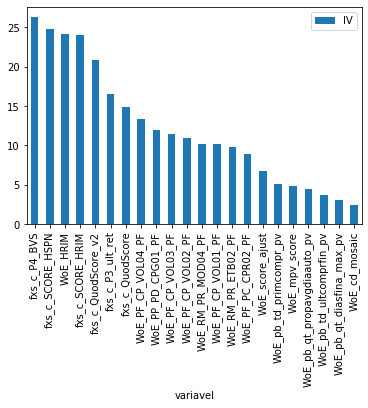

In [0]:
tab_IV.sort_values('IV',ascending=False).plot.bar(x='variavel', y='IV')

## GridSearch

In [0]:
X=X_geral

prefixos = []
safras_dev = [safra for safra in base_ncli_pd.Safra_main.unique() if safra < pd.to_datetime("2021-11")]
safras_teste = [safra for safra in base_ncli_pd.Safra_main.unique() if safra > pd.to_datetime("2021-11") and safra < pd.to_datetime("2022-01")]
safras_nov = [pd.to_datetime("2021-11")]

variaveis_PF = [col for col in base_ncli_pd.columns if col.endswith("PF")]
variaveis_continuas = [col for col in base_ncli_pd.columns if "WoE" not in col and "_PF" in col]

restrito = [
 'WoE_score_ajust',
 'WoE_PF_CP_VOL04_PF',
 'P4_BVS',
 'QuodScore_v2',
 'SCORE_HSPN'
]

aberto = [
  *variaveis_PF,
 'WoE_cd_mosaic',
 'WoE_score_ajust',
 'P4_BVS',
 'QuodScore_v2',
 'SCORE_HSPN'
]

aberto_continuo = [
  *variaveis_continuas,
  'score_ajust',
  'P4_BVS',
  'QuodScore_v2',
  'SCORE_HSPN'
]

X_restrito=X[restrito]
X_aberto=X[aberto]
X_aberto_continuo=X[aberto_continuo]

vis = Visualizador(base=base_ncli_pd, base_cat=base_ncli_cat)

###Adaboost WoE

#### Restrito

In [0]:
prefixo = "ab_restrito"
prefixos.append(prefixo)

prefixos.insert(0, "ab_restrito")
X_train, X_test, y_train, y_test = train_test_split(X_restrito, y, train_size=.7, random_state=1109)

modelo_ab, df_resultados, melhoria = encontra_modelo(classificador="adaboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 27.9s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 1.4min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 2.7min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 5.5min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 8.9min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed: 18.1min finished
Aumento na acurácia de 3.91%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_ab.predict_proba(X_train[restrito])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_ab.predict_proba(temp_test[restrito])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (29.20609368720416, 64003, 3.167039045044764, 61976, 2027)
KS teste: (23.573424409669038, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = restrito
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_ab, X_train, X_test, y_train, y_test, target, nscores=cols, restrito=restrito, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_ab_restrito,WoE_score_ajust,WoE_PF_CP_VOL04_PF,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_ab_restrito,,,,,,
0,9.465792,4.477342,4.838235,7.508772,7.709251,6.964746
1,6.184292,3.500420,NaN,5.254777,4.809976,5.889496
2,4.929178,2.647204,2.669606,3.998001,4.263786,4.428251
3,3.672457,2.717190,2.031286,4.363313,3.690945,4.482072
4,2.605119,2.813688,2.950541,2.850575,3.217822,3.537618
5,3.321364,NaN,NaN,2.976455,3.016241,3.090728
6,3.054449,NaN,NaN,2.424830,3.044496,2.564103
7,1.877347,NaN,NaN,2.287105,1.892744,2.417883
8,1.306306,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto

In [0]:
prefixo = "ab_aberto"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto, y, train_size=.7, random_state=1109)

modelo_ab, df_resultados, melhoria = encontra_modelo(classificador="adaboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 41.5s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 2.1min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 4.1min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 8.2min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed: 26.8min finished
Aumento na acurácia de 4.19%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_ab.predict_proba(X_train[aberto])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_ab.predict_proba(temp_test[aberto])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (35.68585423744723, 64003, 3.167039045044764, 61976, 2027)
KS teste: (21.84837840495884, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = aberto
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_ab, X_train, X_test, y_train, y_test, target, nscores=cols, aberto=aberto, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_ab_aberto,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_cd_mosaic,WoE_score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_ab_aberto,,,,,,,,,,,,,,
0.0,9.515096,4.503741,4.469501,4.708745,4.850585,4.406365,4.838235,4.422021,4.675082,4.478083,4.477342,7.508772,7.709251,6.964746
1.0,5.573350,2.950500,2.756036,2.676580,2.661505,2.837989,NaN,2.538715,2.704309,3.139575,3.500420,5.254777,4.809976,5.889496
2.0,5.221097,2.287959,2.467344,2.254197,2.183803,2.808482,2.669606,2.695361,NaN,3.636364,2.647204,3.998001,4.263786,4.428251
3.0,3.859306,2.863033,NaN,2.838847,2.759557,NaN,2.031286,3.104464,NaN,3.504043,2.717190,4.363313,3.690945,4.482072
4.0,2.875399,NaN,NaN,NaN,NaN,NaN,2.950541,NaN,NaN,2.743764,2.813688,2.850575,3.217822,3.537618
5.0,2.447402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976455,3.016241,3.090728
6.0,2.207912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.424830,3.044496,2.564103
7.0,1.563240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.287105,1.892744,2.417883
8.0,2.134423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto Contínuo

In [0]:
prefixo = "ab_aberto_continuo"
prefixos.append(prefixo)

prefixos.insert(2, prefixo)
X_train, X_test, y_train, y_test = train_test_split(X_aberto_continuo, y, train_size=.7, random_state=1109)

modelo_ab, df_resultados, melhoria = encontra_modelo(classificador="adaboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=3, n_repeticoes=2)

Fitting 6 folds for each of 320 candidates, totalling 1920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 22.5s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 1.1min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 2.7min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 4.8min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 7.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 8.9min finished
Aumento na acurácia de 3.83%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_ab.predict_proba(X_train[aberto_continuo])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_ab.predict_proba(temp_test[aberto_continuo])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (27.395659755046893, 64003, 3.167039045044764, 61976, 2027)
KS teste: (23.484180373077745, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = aberto_continuo
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_ab, X_train, X_test, y_train, y_test, target, nscores=cols, continuo=aberto_continuo, prefixo=prefixo, safras=safras_dev, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_ab_aberto_continuo,score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_ab_aberto_continuo,,,,,
0,8.370044,4.771979,7.508772,7.709251,6.964746
1,5.752212,3.612479,5.254777,4.809976,5.889496
2,5.217966,3.429204,3.998001,4.263786,4.428251
3,3.913248,3.498057,4.363313,3.690945,4.482072
4,3.380402,2.565344,2.850575,3.217822,3.537618
5,3.339605,2.642487,2.976455,3.016241,3.090728
6,2.179837,2.935010,2.424830,3.044496,2.564103
7,1.948669,2.906404,2.287105,1.892744,2.417883
8,1.336516,2.473795,1.642819,2.037201,1.629992


### LightGBM WoE

#### Restrito

In [0]:
prefixo = "lgbm_restrito"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_restrito, y, train_size=.7, random_state=1109)

modelo_lgbm, df_resultados, melhoria = encontra_modelo(classificador="light_gbm", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 4608 candidates, totalling 46080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 8.0s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 20.6s
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 39.7s
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 59.8s
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 1.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 1.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 2.3min
[Parallel(n_jobs=-1)]: Done 3986 tasks | elapsed: 3.0min
[Parallel(n_jobs=-1)]: Done 4936 tasks | elapsed: 3.9min
[Parallel(n_jobs=-1)]: Done 5986 tasks | elapsed: 4.6min
[Parallel(n_jobs=-1)]: Done 7136 tasks | elapsed: 5.7min
[Parallel(n_jobs=-1)]: Done 8386 tasks | elapsed: 6.6min
[Parallel(n_jobs=-1)]: Done 9736 tasks | elapsed: 7.7min
[Parallel(n_jobs=-1)]: Done 11186 tasks | elapsed: 8.7min
[Parallel(n_jobs=-1)]: Done 12736 tasks | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 14386 tasks | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 16136 tasks | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 17986 tasks | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 19936 tasks | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 21986 tasks | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 24136 tasks | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 26386 tasks | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 28736 tasks | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 31186 tasks | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 33736 tasks | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 36386 tasks | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 39136 tasks | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 41986 tasks | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 44936 tasks | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 46080 out of 46080 | elapsed: 35.6min finished
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[1]	valid_0's auc: 0.62029
[2]	valid_0's auc: 0.631994
[3]	valid_0's auc: 0.638946
[4]	valid_0's auc: 0.641921
[5]	valid_0's auc: 0.638196
[6]	valid_0's auc: 0.643617
[7]	valid_0's auc: 0.645533
[8]	valid_0's auc: 0.641242
[9]	valid_0's auc: 0.644522
[10]	valid_0's auc: 0.642328
[11]	valid_0's auc: 0.641234
[12]	valid_0's auc: 0.639395
[13]	valid_0's auc: 0.638747
[14]	valid_0's auc: 0.639199
[15]	valid_0's auc: 0.640118
[16]	valid_0's auc: 0.640918
[17]	valid_0's auc: 0.64032
[18]	valid_0's auc: 0.640791
[19]	valid_0's auc: 0.640083
[20]	valid_0's auc: 0.64031
[21]	valid_0's auc: 0.640204
[22]	valid_0's auc: 0.638177
[23]	valid_0's auc: 0.636433
[24]	valid_0's auc: 0.638994
[25]	valid_0's auc: 0.638339
[26]	valid_0's auc: 0.641163
[27]	valid_0's auc: 0.643149
[28]	valid_0's auc: 0.642555
[29]	valid_0's auc: 0.642281
[30]	valid_0's auc: 0.641242
[31]	valid_0's auc: 0.639697
[32]	valid_0's auc: 0.638587
[33]	valid_0's auc: 0.638117
[34]	valid_0's auc: 0.638067
[35]	valid_0's auc: 0.637018
[36]	valid_0's auc: 0.636812
[37]	valid_0's auc: 0.636566
[38]	valid_0's auc: 0.634424
[39]	valid_0's auc: 0.634959
[40]	valid_0's auc: 0.634477
[41]	valid_0's auc: 0.635413
[42]	valid_0's auc: 0.632875
[43]	valid_0's auc: 0.632149
[44]	valid_0's auc: 0.632216
[45]	valid_0's auc: 0.632453
[46]	valid_0's auc: 0.631938
[47]	valid_0's auc: 0.629098
[48]	valid_0's auc: 0.629194
[49]	valid_0's auc: 0.629824
[50]	valid_0's auc: 0.630065
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(X_train[restrito])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(temp_test[restrito])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (27.432070399293284, 64003, 3.167039045044764, 61976, 2027)
KS teste: (20.85339372485468, 27430, 3.328472475391907, 26517, 913)

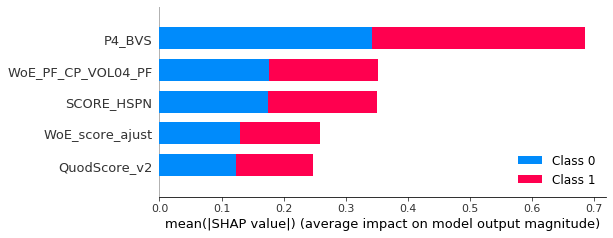

In [0]:
shap_values = shap.TreeExplainer(modelo_lgbm).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

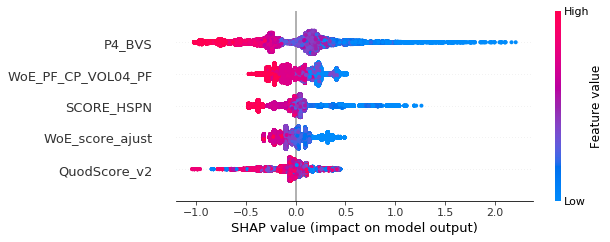

In [0]:
shap.summary_plot(shap_values[1],X_train)

In [0]:
cols = restrito
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_lgbm, X_train, X_test, y_train, y_test, target, nscores=cols, restrito=restrito, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_lgbm_restrito,WoE_score_ajust,WoE_PF_CP_VOL04_PF,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_lgbm_restrito,,,,,,
0.0,8.947368,4.477342,4.838235,7.508772,7.709251,6.964746
1.0,6.024096,3.500420,NaN,5.254777,4.809976,5.889496
2.0,4.397801,2.647204,2.669606,3.998001,4.263786,4.428251
3.0,3.564815,2.717190,2.031286,4.363313,3.690945,4.482072
4.0,3.080082,2.813688,2.950541,2.850575,3.217822,3.537618
5.0,2.696420,NaN,NaN,2.976455,3.016241,3.090728
6.0,2.590890,NaN,NaN,2.424830,3.044496,2.564103
7.0,2.309059,NaN,NaN,2.287105,1.892744,2.417883
8.0,1.672085,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto

In [0]:
prefixo = "lgbm_aberto"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto, y, train_size=.7, random_state=1109)

modelo_lgbm, df_resultados, melhoria = encontra_modelo(classificador="light_gbm", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 4608 candidates, totalling 46080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 13.3s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 35.9s
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 1.2min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 1.7min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 2.3min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 2.9min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 3.7min
[Parallel(n_jobs=-1)]: Done 3986 tasks | elapsed: 4.9min
[Parallel(n_jobs=-1)]: Done 4936 tasks | elapsed: 5.9min
[Parallel(n_jobs=-1)]: Done 5986 tasks | elapsed: 6.9min
[Parallel(n_jobs=-1)]: Done 7136 tasks | elapsed: 8.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks | elapsed: 9.6min
[Parallel(n_jobs=-1)]: Done 9736 tasks | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 11186 tasks | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 12736 tasks | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 14386 tasks | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 16136 tasks | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 17986 tasks | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 19936 tasks | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 21986 tasks | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 24136 tasks | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 26386 tasks | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 28736 tasks | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 31186 tasks | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 33736 tasks | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 36386 tasks | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 39136 tasks | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 41986 tasks | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 44936 tasks | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 46080 out of 46080 | elapsed: 52.4min finished
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's auc: 0.609901
[2]	valid_0's auc: 0.631714
[3]	valid_0's auc: 0.639616
[4]	valid_0's auc: 0.641387
[5]	valid_0's auc: 0.638716
[6]	valid_0's auc: 0.643025
[7]	valid_0's auc: 0.646769
[8]	valid_0's auc: 0.649875
[9]	valid_0's auc: 0.649167
[10]	valid_0's auc: 0.650523
[11]	valid_0's auc: 0.64991
[12]	valid_0's auc: 0.651229
[13]	valid_0's auc: 0.650743
[14]	valid_0's auc: 0.651329
[15]	valid_0's auc: 0.649433
[16]	valid_0's auc: 0.646489
[17]	valid_0's auc: 0.645839
[18]	valid_0's auc: 0.645489
[19]	valid_0's auc: 0.646915
[20]	valid_0's auc: 0.645801
[21]	valid_0's auc: 0.643553
[22]	valid_0's auc: 0.642996
[23]	valid_0's auc: 0.643157
[24]	valid_0's auc: 0.646385
[25]	valid_0's auc: 0.6466
[26]	valid_0's auc: 0.64513
[27]	valid_0's auc: 0.644474
[28]	valid_0's auc: 0.644726
[29]	valid_0's auc: 0.644776
[30]	valid_0's auc: 0.64305
[31]	valid_0's auc: 0.643318
[32]	valid_0's auc: 0.642738
[33]	valid_0's auc: 0.641639
[34]	valid_0's auc: 0.641753
[35]	valid_0's auc: 0.640748
[36]	valid_0's auc: 0.640885
[37]	valid_0's auc: 0.640528
[38]	valid_0's auc: 0.641984
[39]	valid_0's auc: 0.64202
[40]	valid_0's auc: 0.644062
[41]	valid_0's auc: 0.644339
[42]	valid_0's auc: 0.645176
[43]	valid_0's auc: 0.644893
[44]	valid_0's auc: 0.645019
[45]	valid_0's auc: 0.645794
[46]	valid_0's auc: 0.644024
[47]	valid_0's auc: 0.643117
[48]	valid_0's auc: 0.640886
[49]	valid_0's auc: 0.642627
[50]	valid_0's auc: 0.642704
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(X_train[aberto])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(temp_test[aberto])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (27.5158146422547, 64003, 3.167039045044764, 61976, 2027)
KS teste: (22.690835336326227, 27430, 3.328472475391907, 26517, 913)

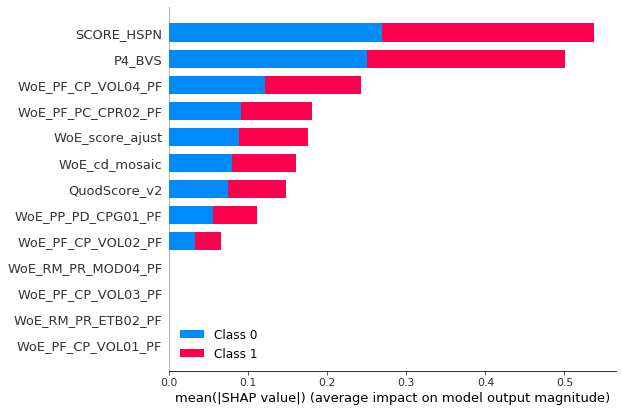

In [0]:
shap_values = shap.TreeExplainer(modelo_lgbm).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

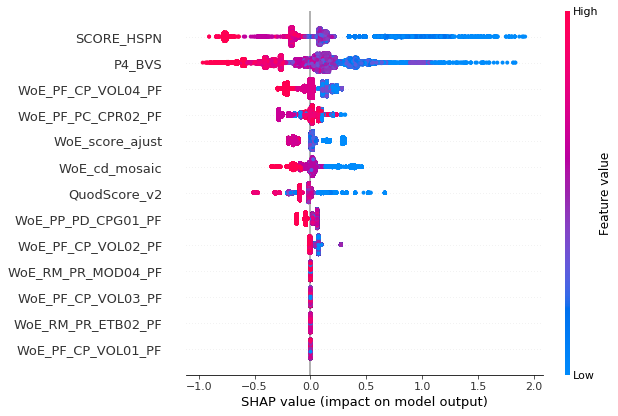

In [0]:
shap.summary_plot(shap_values[1],X_train)

In [0]:
cols = aberto
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_lgbm, X_train, X_test, y_train, y_test, target, nscores=cols, aberto=aberto, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_lgbm_aberto,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_cd_mosaic,WoE_score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_lgbm_aberto,,,,,,,,,,,,,,
0,9.838710,4.503741,4.469501,4.708745,4.850585,4.406365,4.838235,4.422021,4.675082,4.478083,4.477342,7.508772,7.709251,6.964746
1,5.830721,2.950500,2.756036,2.676580,2.661505,2.837989,NaN,2.538715,2.704309,3.139575,3.500420,5.254777,4.809976,5.889496
2,3.860590,2.287959,2.467344,2.254197,2.183803,2.808482,2.669606,2.695361,NaN,3.636364,2.647204,3.998001,4.263786,4.428251
3,4.352332,2.863033,NaN,2.838847,2.759557,NaN,2.031286,3.104464,NaN,3.504043,2.717190,4.363313,3.690945,4.482072
4,2.627939,NaN,NaN,NaN,NaN,NaN,2.950541,NaN,NaN,2.743764,2.813688,2.850575,3.217822,3.537618
5,2.846814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976455,3.016241,3.090728
6,2.780310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.424830,3.044496,2.564103
7,1.834061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.287105,1.892744,2.417883
8,1.979762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto Contínuo

In [0]:
prefixo = "lgbm_aberto_continuo"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto_continuo, y, train_size=.7, random_state=1109)

modelo_lgbm, df_resultados, melhoria = encontra_modelo(classificador="light_gbm", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 4608 candidates, totalling 46080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 8.5s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 21.9s
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 41.8s
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 1.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 1.9min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 2.4min
[Parallel(n_jobs=-1)]: Done 3986 tasks | elapsed: 3.2min
[Parallel(n_jobs=-1)]: Done 4936 tasks | elapsed: 3.9min
[Parallel(n_jobs=-1)]: Done 5986 tasks | elapsed: 4.6min
[Parallel(n_jobs=-1)]: Done 7136 tasks | elapsed: 5.6min
[Parallel(n_jobs=-1)]: Done 8386 tasks | elapsed: 6.4min
[Parallel(n_jobs=-1)]: Done 9736 tasks | elapsed: 7.5min
[Parallel(n_jobs=-1)]: Done 11186 tasks | elapsed: 8.5min
[Parallel(n_jobs=-1)]: Done 12736 tasks | elapsed: 9.9min
[Parallel(n_jobs=-1)]: Done 14386 tasks | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 16136 tasks | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 17986 tasks | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 19936 tasks | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 21986 tasks | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 24136 tasks | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 26386 tasks | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 28736 tasks | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 31186 tasks | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 33736 tasks | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 36386 tasks | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 39136 tasks | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 41986 tasks | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 44936 tasks | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 46080 out of 46080 | elapsed: 34.7min finished
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[1]	valid_0's auc: 0.620753
[2]	valid_0's auc: 0.636548
[3]	valid_0's auc: 0.640858
[4]	valid_0's auc: 0.649145
[5]	valid_0's auc: 0.649171
[6]	valid_0's auc: 0.650731
[7]	valid_0's auc: 0.650483
[8]	valid_0's auc: 0.65262
[9]	valid_0's auc: 0.651569
[10]	valid_0's auc: 0.652076
[11]	valid_0's auc: 0.651804
[12]	valid_0's auc: 0.650034
[13]	valid_0's auc: 0.648885
[14]	valid_0's auc: 0.649865
[15]	valid_0's auc: 0.649587
[16]	valid_0's auc: 0.648479
[17]	valid_0's auc: 0.647695
[18]	valid_0's auc: 0.649869
[19]	valid_0's auc: 0.651269
[20]	valid_0's auc: 0.651774
[21]	valid_0's auc: 0.651835
[22]	valid_0's auc: 0.651618
[23]	valid_0's auc: 0.650973
[24]	valid_0's auc: 0.649703
[25]	valid_0's auc: 0.649471
[26]	valid_0's auc: 0.64931
[27]	valid_0's auc: 0.648733
[28]	valid_0's auc: 0.648925
[29]	valid_0's auc: 0.648023
[30]	valid_0's auc: 0.648143
[31]	valid_0's auc: 0.648346
[32]	valid_0's auc: 0.647601
[33]	valid_0's auc: 0.646129
[34]	valid_0's auc: 0.645538
[35]	valid_0's auc: 0.644891
[36]	valid_0's auc: 0.645022
[37]	valid_0's auc: 0.645839
[38]	valid_0's auc: 0.645929
[39]	valid_0's auc: 0.646347
[40]	valid_0's auc: 0.6463
[41]	valid_0's auc: 0.645311
[42]	valid_0's auc: 0.644189
[43]	valid_0's auc: 0.643587
[44]	valid_0's auc: 0.643807
[45]	valid_0's auc: 0.643876
[46]	valid_0's auc: 0.643682
[47]	valid_0's auc: 0.643496
[48]	valid_0's auc: 0.642535
[49]	valid_0's auc: 0.641647
[50]	valid_0's auc: 0.641001
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(X_train[aberto_continuo])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_lgbm.predict_proba(temp_test[aberto_continuo])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (27.553029264347856, 64003, 3.167039045044764, 61976, 2027)
KS teste: (23.19418888566846, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = aberto_continuo
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_lgbm, X_train, X_test, y_train, y_test, target, nscores=cols, continuo=aberto_continuo, prefixo=prefixo, safras=safras_dev, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_lgbm_aberto_continuo,score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_lgbm_aberto_continuo,,,,,
0,8.333333,4.771979,7.508772,7.709251,6.964746
1,4.974160,3.612479,5.254777,4.809976,5.889496
2,5.379558,3.429204,3.998001,4.263786,4.428251
3,4.589995,3.498057,4.363313,3.690945,4.482072
4,3.151733,2.565344,2.850575,3.217822,3.537618
5,2.846379,2.642487,2.976455,3.016241,3.090728
6,2.939825,2.935010,2.424830,3.044496,2.564103
7,2.075646,2.906404,2.287105,1.892744,2.417883
8,1.433962,2.473795,1.642819,2.037201,1.629992


### Random Forest

#### Restrito

In [0]:
prefixo = "rf_restrito"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_restrito, y, train_size=.7, random_state=1109)

modelo_rf, df_resultados, melhoria = encontra_modelo(classificador="random_forest", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 50.1s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 2.4min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 5.1min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 9.4min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 33.1min finished
Aumento na acurácia de 0.01%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_rf.predict_proba(X_train[restrito])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_rf.predict_proba(temp_test[restrito])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (25.426513431779274, 64003, 3.167039045044764, 61976, 2027)
KS teste: (23.08231785507332, 27430, 3.328472475391907, 26517, 913)

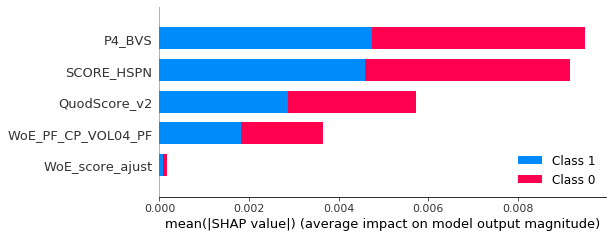

In [0]:
shap_values = shap.TreeExplainer(modelo_rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

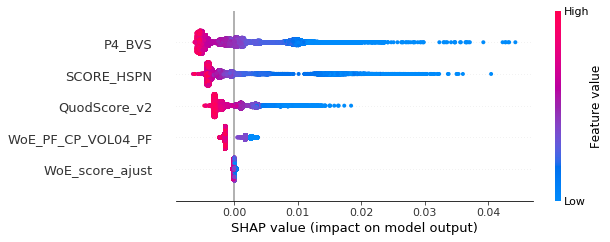

In [0]:
shap.summary_plot(shap_values[1],X_train)

In [0]:
cols = restrito
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_rf, X_train, X_test, y_train, y_test, target, nscores=cols, restrito=restrito, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_rf_restrito,WoE_score_ajust,WoE_PF_CP_VOL04_PF,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_rf_restrito,,,,,,
0.0,9.756098,4.477342,4.838235,7.508772,7.709251,6.964746
1.0,5.677419,3.500420,NaN,5.254777,4.809976,5.889496
2.0,4.622496,2.647204,2.669606,3.998001,4.263786,4.428251
3.0,4.074074,2.717190,2.031286,4.363313,3.690945,4.482072
4.0,3.178156,2.813688,2.950541,2.850575,3.217822,3.537618
5.0,2.875264,NaN,NaN,2.976455,3.016241,3.090728
6.0,2.518580,NaN,NaN,2.424830,3.044496,2.564103
7.0,2.199345,NaN,NaN,2.287105,1.892744,2.417883
8.0,1.568441,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto

In [0]:
prefixo = "rf_aberto"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto, y, train_size=.7, random_state=1109)

modelo_rf, df_resultados, melhoria = encontra_modelo(classificador="random_forest", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 43.0s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 2.0min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 4.1min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 7.5min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 24.2min finished
Aumento na acurácia de -0.01%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_rf.predict_proba(X_train[aberto])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_rf.predict_proba(temp_test[aberto])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (24.83235071850784, 64003, 3.167039045044764, 61976, 2027)
KS teste: (21.86902274888568, 27430, 3.328472475391907, 26517, 913)

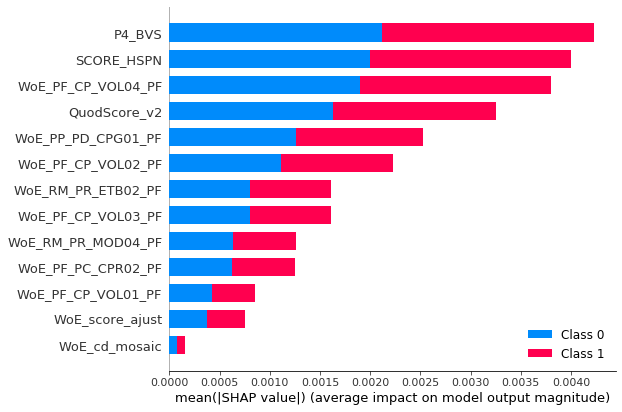

In [0]:
shap_values = shap.TreeExplainer(modelo_rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

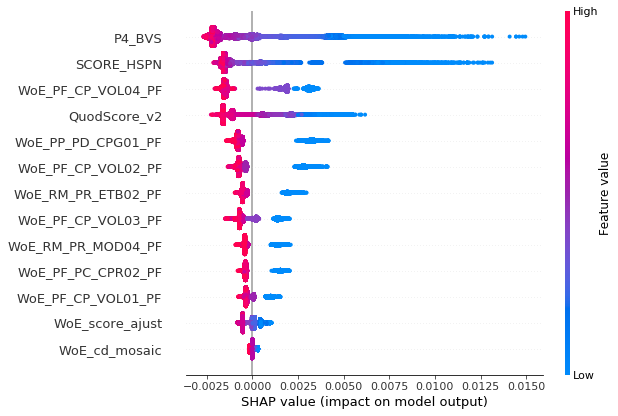

In [0]:
shap.summary_plot(shap_values[1],X_train)

In [0]:
cols = aberto
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_rf, X_train, X_test, y_train, y_test, target, nscores=cols, aberto=aberto, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_rf_aberto,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_cd_mosaic,WoE_score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_rf_aberto,,,,,,,,,,,,,,
0,8.799267,4.503741,4.469501,4.708745,4.850585,4.406365,4.838235,4.422021,4.675082,4.478083,4.477342,7.508772,7.709251,6.964746
1,6.467977,2.950500,2.756036,2.676580,2.661505,2.837989,NaN,2.538715,2.704309,3.139575,3.500420,5.254777,4.809976,5.889496
2,5.046404,2.287959,2.467344,2.254197,2.183803,2.808482,2.669606,2.695361,NaN,3.636364,2.647204,3.998001,4.263786,4.428251
3,3.554041,2.863033,NaN,2.838847,2.759557,NaN,2.031286,3.104464,NaN,3.504043,2.717190,4.363313,3.690945,4.482072
4,2.991840,NaN,NaN,NaN,NaN,NaN,2.950541,NaN,NaN,2.743764,2.813688,2.850575,3.217822,3.537618
5,3.097731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976455,3.016241,3.090728
6,2.636282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.424830,3.044496,2.564103
7,2.391391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.287105,1.892744,2.417883
8,1.179361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto Contínuo

In [0]:
prefixo = "rf_aberto_continuo"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto_continuo, y, train_size=.7, random_state=1109)

modelo_rf, df_resultados, melhoria = encontra_modelo(classificador="random_forest", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks | elapsed: 56.0s
[Parallel(n_jobs=-1)]: Done 386 tasks | elapsed: 2.7min
[Parallel(n_jobs=-1)]: Done 736 tasks | elapsed: 5.6min
[Parallel(n_jobs=-1)]: Done 1186 tasks | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1736 tasks | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 38.3min finished
Aumento na acurácia de 0.01%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_rf.predict_proba(X_train[aberto_continuo])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_rf.predict_proba(temp_test[aberto_continuo])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (24.667768493098436, 64003, 3.167039045044764, 61976, 2027)
KS teste: (22.876089202896598, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = aberto_continuo
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_rf, X_train, X_test, y_train, y_test, target, nscores=cols, continuo=aberto_continuo, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_rf_aberto_continuo,score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_rf_aberto_continuo,,,,,
0,9.783631,4.771979,7.508772,7.709251,6.964746
1,5.129829,3.612479,5.254777,4.809976,5.889496
2,4.266797,3.429204,3.998001,4.263786,4.428251
3,4.080653,3.498057,4.363313,3.690945,4.482072
4,3.533095,2.565344,2.850575,3.217822,3.537618
5,3.228410,2.642487,2.976455,3.016241,3.090728
6,2.307692,2.935010,2.424830,3.044496,2.564103
7,1.637765,2.906404,2.287105,1.892744,2.417883
8,1.933301,2.473795,1.642819,2.037201,1.629992


### XgBoost

#### Restrito

In [0]:
prefixo = "xg_restrito"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_restrito, y, train_size=.7, random_state=1109)


hiperparams = {}

modelo_xg, df_resultados, melhoria = encontra_modelo(hiperparams=hiperparams, classificador="xgboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2 out of 10 | elapsed: 2.4s remaining: 9.5s
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 2.5s finished
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_xg.predict_proba(X_train[restrito])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_xg.predict_proba(temp_test[restrito])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (61.296371929767815, 64003, 3.167039045044764, 61976, 2027)
KS teste: (20.186198929773752, 27430, 3.328472475391907, 26517, 913)

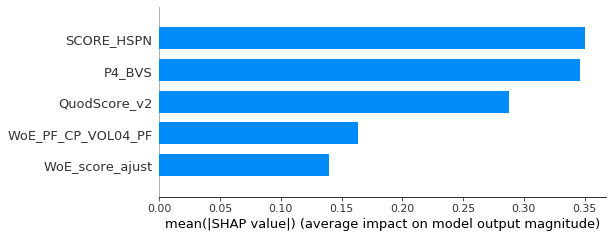

In [0]:
shap_values = shap.TreeExplainer(modelo_xg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [0]:
shap_values[1]

Out[221]: array([ 0.44556928, -0.36485487, 0.28823882, 0.07916814, -0.19513194],
 dtype=float32)

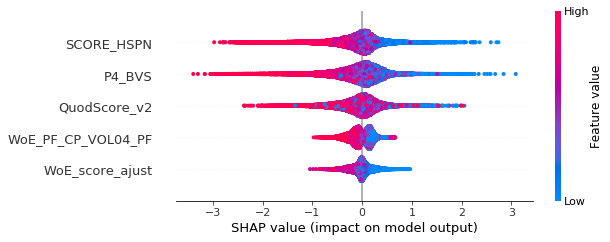

In [0]:
shap.summary_plot(shap_values,X_train)

In [0]:
cols = restrito
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_xg, X_train, X_test, y_train, y_test, target, nscores=cols, restrito=restrito, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_xg_restrito,WoE_score_ajust,WoE_PF_CP_VOL04_PF,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_xg_restrito,,,,,,
0.0,6.478034,4.477342,4.838235,7.508772,7.709251,6.964746
1.0,5.053947,3.500420,NaN,5.254777,4.809976,5.889496
2.0,4.739583,2.647204,2.669606,3.998001,4.263786,4.428251
3.0,4.052685,2.717190,2.031286,4.363313,3.690945,4.482072
4.0,3.325301,2.813688,2.950541,2.850575,3.217822,3.537618
5.0,2.805516,NaN,NaN,2.976455,3.016241,3.090728
6.0,2.864198,NaN,NaN,2.424830,3.044496,2.564103
7.0,2.081448,NaN,NaN,2.287105,1.892744,2.417883
8.0,2.253646,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto

In [0]:
prefixo = "xg_aberto"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto, y, train_size=.7, random_state=1109)

hiperparams = {}

modelo_xg, df_resultados, melhoria = encontra_modelo(hiperparams=hiperparams, classificador="xgboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2 out of 10 | elapsed: 3.8s remaining: 15.2s
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 4.0s finished
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_xg.predict_proba(X_train[aberto])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_xg.predict_proba(temp_test[aberto])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (70.71155191668636, 64003, 3.167039045044764, 61976, 2027)
KS teste: (17.79228526898015, 27430, 3.328472475391907, 26517, 913)

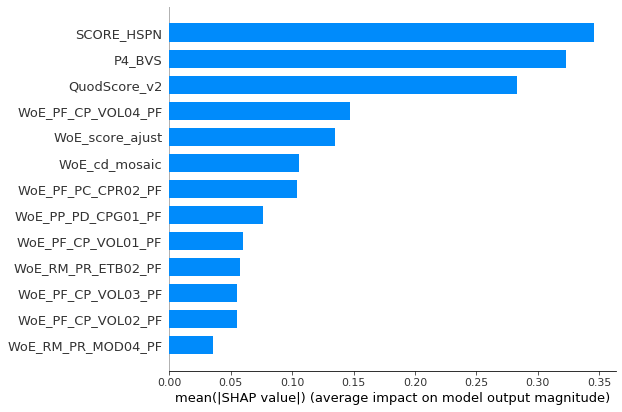

In [0]:
shap_values = shap.TreeExplainer(modelo_xg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

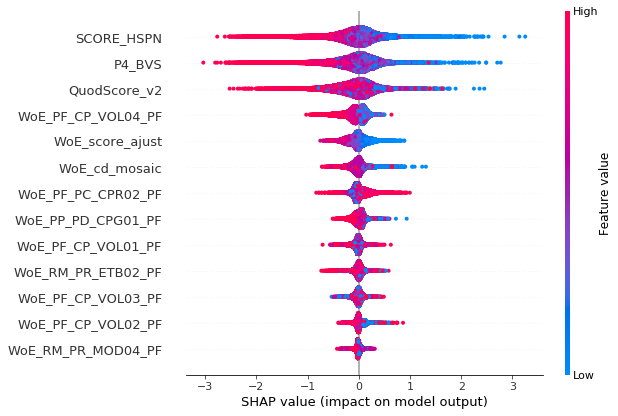

In [0]:
shap.summary_plot(shap_values,X_train)

In [0]:
cols = aberto
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_xg, X_train, X_test, y_train, y_test, target, nscores=cols, aberto=aberto, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_xg_aberto,WoE_PF_CP_VOL01_PF,WoE_RM_PR_ETB02_PF,WoE_PF_CP_VOL02_PF,WoE_PF_CP_VOL03_PF,WoE_PP_PD_CPG01_PF,WoE_PF_CP_VOL04_PF,WoE_PF_PC_CPR02_PF,WoE_RM_PR_MOD04_PF,WoE_cd_mosaic,WoE_score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_xg_aberto,,,,,,,,,,,,,,
0.0,7.007708,4.503741,4.469501,4.708745,4.850585,4.406365,4.838235,4.422021,4.675082,4.478083,4.477342,7.508772,7.709251,6.964746
1.0,5.306799,2.950500,2.756036,2.676580,2.661505,2.837989,NaN,2.538715,2.704309,3.139575,3.500420,5.254777,4.809976,5.889496
2.0,4.278351,2.287959,2.467344,2.254197,2.183803,2.808482,2.669606,2.695361,NaN,3.636364,2.647204,3.998001,4.263786,4.428251
3.0,3.274559,2.863033,NaN,2.838847,2.759557,NaN,2.031286,3.104464,NaN,3.504043,2.717190,4.363313,3.690945,4.482072
4.0,3.353973,NaN,NaN,NaN,NaN,NaN,2.950541,NaN,NaN,2.743764,2.813688,2.850575,3.217822,3.537618
5.0,3.479942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976455,3.016241,3.090728
6.0,2.476931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.424830,3.044496,2.564103
7.0,2.454545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.287105,1.892744,2.417883
8.0,2.027941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642819,2.037201,1.629992


#### Aberto Contínuo

In [0]:
prefixo = "xg_aberto_continuo"
prefixos.append(prefixo)

X_train, X_test, y_train, y_test = train_test_split(X_aberto_continuo, y, train_size=.7, random_state=1109)

hiperparams = {}

modelo_xg, df_resultados, melhoria = encontra_modelo(hiperparams=hiperparams, classificador="xgboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_divisoes=5, n_repeticoes=2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2 out of 10 | elapsed: 2.2s remaining: 8.8s
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 2.3s finished
Aumento na acurácia de 0.00%

In [0]:
target = 'inad30'

temp_train=X_train.join(y_train,rsuffix='r')
temp_train[f'yhat_{prefixo}']=modelo_xg.predict_proba(X_train[aberto_continuo])[:,1]
print("KS treino: " , calc_perf(temp_train,f'yhat_{prefixo}', target))
  
temp_test=X_test.join(y_test,rsuffix='r')
temp_test[f'yhat_{prefixo}']=modelo_xg.predict_proba(temp_test[aberto_continuo])[:,1]
print("KS teste: " , calc_perf(temp_test,f'yhat_{prefixo}', target))

KS treino: (61.7999366879386, 64003, 3.167039045044764, 61976, 2027)
KS teste: (19.434084753582, 27430, 3.328472475391907, 26517, 913)

In [0]:
cols = aberto_continuo
scores = [f"yhat_{prefixo}", *cols]

tab_KS = calcula_KS(modelo_xg, X_train, X_test, y_train, y_test, target, nscores=cols, continuo=aberto_continuo, prefixo=prefixo, base_pd=base_ncli_pd, base_cat=base_ncli_cat)
tab_KS

vis.tabela_qs(safras_dev, "Safra_main", scores)
vis.tabela_qs(safras_nov, "Safra_main", scores)

col_0,yhat_xg_aberto_continuo,score_ajust,P4_BVS,QuodScore_v2,SCORE_HSPN
qsyhat_xg_aberto_continuo,,,,,
0.0,6.749311,4.771979,7.508772,7.709251,6.964746
1.0,4.700162,3.612479,5.254777,4.809976,5.889496
2.0,4.112676,3.429204,3.998001,4.263786,4.428251
3.0,3.948052,3.498057,4.363313,3.690945,4.482072
4.0,3.547459,2.565344,2.850575,3.217822,3.537618
5.0,3.676826,2.642487,2.976455,3.016241,3.090728
6.0,2.442529,2.935010,2.424830,3.044496,2.564103
7.0,2.689721,2.906404,2.287105,1.892744,2.417883
8.0,1.469279,2.473795,1.642819,2.037201,1.629992


### Validação

In [0]:
target = 'inad30'
modelo_logistica = "yhat_blend"

cols0 = [f'yhat_{prefixo}' for prefixo in prefixos]
cols = [*cols0, modelo_logistica, 'P4_BVS','SCORE_HSPN','QuodScore_v2']
safras_ks = [safra for safra in pd.DatetimeIndex(base_ncli_pd["Safra_main"].unique()) if safra.year < 2022 and safra.month <= 12]

vis.tabela_ks_por_safra(target, modelos=cols, safras=safras_ks)

modelo,P4_BVS,QuodScore_v2,SCORE_HSPN,yhat_ab_aberto,yhat_ab_aberto_continuo,yhat_ab_restrito,yhat_blend,yhat_lgbm_aberto,yhat_lgbm_aberto_continuo,yhat_lgbm_restrito,yhat_rf_aberto,yhat_rf_aberto_continuo,yhat_rf_restrito,yhat_xg_aberto,yhat_xg_aberto_continuo,yhat_xg_restrito
Safra,,,,,,,,,,,,,,,,
2021-08-01,20.2280,18.2180,20.0644,31.0066,25.5438,26.9064,23.9998,26.7393,26.1854,25.8084,22.5248,24.3173,24.2431,53.1622,48.1244,47.0264
2021-09-01,21.7427,20.0108,21.5356,31.9497,26.9794,27.8510,25.0739,26.1810,25.7785,26.8145,26.1416,23.6244,25.2870,53.0476,47.6784,48.0759
2021-10-01,21.1807,20.3182,19.1208,31.3707,26.8121,28.8284,25.6643,26.3184,28.0753,24.1908,24.6431,24.8768,25.8345,52.9860,49.4825,47.9068
2021-11-01,21.2514,17.1391,21.2569,23.6606,24.0151,23.4815,25.6936,23.5246,23.3480,22.9526,23.2624,21.9504,22.6804,17.6940,17.5606,19.0516
2021-12-01,14.6073,15.1148,17.1131,19.9987,19.2921,20.7733,19.4595,18.1139,17.9312,18.1808,19.8185,17.5913,19.3639,15.2154,13.4905,16.1199


### Gráficos

#### KS por safra

In [0]:
graficos = vis.ks_por_safra(cols, safras_dev)

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-4255241442308405> in <module> 
 ----> 1 graficos = vis . ks_por_safra ( cols , safras_dev ) 

 <command-1731702899285260> in ks_por_safra (self, modelos, safras, kind, title, ylabel, figsize, tab_KS_pivot) 
 57 globals ( ) [ f"ax_{opcao}" ] = tab_KS_pivot [ conj_modelos [ opcao ] ] . plot ( kind = kind , title = title , figsize = figsize , marker = '.' , markersize = 16 ) 
 58 else : 
 ---> 59 globals ( ) [ f"ax_{opcao}" ] = self . tab_KS_pivot [ conj_modelos [ opcao ] ] . plot ( kind = kind , title = title , figsize = figsize , marker = '.' , markersize = 14 ) 
 60 plt . ylabel ( "KS" ) 
 61 

 /databricks/python/lib/python3.7/site-packages/pandas/plotting/_core.py in __call__ (self, *args, **kwargs) 
 845 data . columns = label_name
 846 
 --> 847 return plot_backend . plot ( data , kind = kind , ** kwargs ) 
 848 
 849 __call__ . __doc__ = __doc__

 /databricks/python/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py in plot (data, kind, **kwargs) 
 59 kwargs [ "ax" ] = getattr ( ax , "left_ax" , ax ) 
 60 plot_obj = PLOT_CLASSES [ kind ] ( data , ** kwargs ) 
 ---> 61 plot_obj . generate ( ) 
 62 plot_obj . draw ( ) 
 63 return plot_obj . result

 /databricks/python/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py in generate (self) 
 259 def generate ( self ) : 
 260 self . _args_adjust ( ) 
 --> 261 self . _compute_plot_data ( ) 
 262 self . _setup_subplots ( ) 
 263 self . _make_plot ( ) 

 /databricks/python/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py in _compute_plot_data (self) 
 414 numeric_data = numeric_data . copy ( ) 
 415 for col in numeric_data : 
 --> 416 numeric_data [ col ] = np . asarray ( numeric_data [ col ] ) 
 417 
 418 self . data = numeric_data

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in __setitem__ (self, key, value) 
 2936 else : 
 2937 # set column 
 -> 2938 self . _set_item ( key , value ) 
 2939 
 2940 def _setitem_slice ( self , key , value ) : 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in _set_item (self, key, value) 
 2999 self . _ensure_valid_index ( value ) 
 3000 value = self . _sanitize_column ( key , value ) 
 -> 3001 NDFrame . _set_item ( self , key , value ) 
 3002 
 3003 # check if we are modifying a copy 

 /databricks/python/lib/python3.7/site-packages/pandas/core/generic.py in _set_item (self, key, value) 
 3622 
 3623 def _set_item ( self , key , value ) -> None : 
 -> 3624 self . _data . set ( key , value ) 
 3625 self . _clear_item_cache ( ) 
 3626 

 /databricks/python/lib/python3.7/site-packages/pandas/core/internals/managers.py in set (self, item, value) 
 1084 unfit_val_locs = [ ] 
 1085 removed_blknos = [ ] 
 -> 1086 for blkno , val_locs in libinternals . get_blkno_placements ( blknos , group = True ) : 
 1087 blk = self . blocks [ blkno ] 
 1088 blk_locs = blklocs [ val_locs . indexer ] 

 pandas/_libs/internals.pyx in get_blkno_placements () 

 pandas/_libs/internals.pyx in pandas._libs.internals.get_blkno_indexers () 

 ValueError : Buffer has wrong number of dimensions (expected 1, got 0)

In [0]:
restritos = [modelo for modelo in cols if "restrito" in modelo]
abertos = [modelo for modelo in cols if "aberto" in modelo and "continuo" not in modelo]
continuos = [modelo for modelo in cols if "continuo" in modelo]

restritos_blend = [modelo_logistica, *restritos]
abertos_blend = [modelo_logistica, *abertos]
continuos_blend = [modelo_logistica, *continuos]

In [0]:
vis.tab_KS_pivot[restritos_blend].plot(kind="line", title="KS do modelo por safra (Restrito)", figsize=(8,6), marker='.', markersize=14)
plt.ylabel("KS")
plt.xlabel("Safra - 2021")

In [0]:
vis.tab_KS_pivot[abertos_blend].plot.line(title="KS do modelo por safra (Aberto)", figsize=(8,6), marker='.', markersize=14)
plt.ylabel("KS")
plt.xlabel("Safra - 2021")

In [0]:
vis.tab_KS_pivot[continuos_blend].plot.line(title="KS do modelo  por safra (Contínuo)", figsize=(8,6), marker='.', markersize=14)
plt.ylabel("KS")
plt.xlabel("Safra - 2021")

#### Decis Inad

In [0]:
prefixos = list(dict.fromkeys(prefixos))
 
scores = [modelo_logistica, 'P4_BVS', 'SCORE_HSPN', 'QuodScore_v2']

tab_decis = vis.tabela_qs_final(prefixos, scores)
tab_decis

In [0]:
tab_decis[restritos_blend].plot(kind="line", title="Ordenação inad por decil (Restrito)", figsize=(8,6), marker='.', markersize=14 )
plt.xlabel("Decil")
plt.ylabel("%inad30")
plt.legend(title="modelo")

In [0]:
tab_decis[abertos_blend].plot(kind="line", title="Ordenação inad por decil (Aberto)", figsize=(8,6), marker='.', markersize=14 )
plt.xlabel("Decil")
plt.ylabel("%inad30")
plt.legend(title="modelo")

In [0]:
tab_decis[continuos_blend].plot(kind="line", title="Ordenação inad por decil (Contínuo)", figsize=(8,6), marker='.', markersize=14 )
plt.xlabel("Decil")
plt.ylabel("%inad30")
plt.legend(title="modelo")

# Rascunhos